In [1]:
import os
import time
import lmdb
from itertools import chain

from joblib import dump, load

import matplotlib.pyplot as plt
from IPython import display

import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import theano
import theano.tensor as T
import lasagne.layers
import lasagne.nonlinearities 

from tqdm import tqdm_notebook

from nn_utils import build_UNet, iterate_minibatches
from train_data_preparation import prepare_data, extract_random_patches, extract_grid_patches

In [2]:
patch_size = 64
random_state = 42
n_classes = 2

grid_patches_params = {
    'patch_size': patch_size,
    'h_patches_number': 12,
    'w_patches_number': 12,
}

In [3]:
stack_path = '/home/efim/study/10_semester/course_work/all_data/binary_data'
path_X = 'NLM'
path_Y = 'CAC'

In [4]:
stack_names = ['SoilB-2', 'Urna_22', 'carb96558']
stack_proportions = [0.33, 0.33, 0.33]

In [6]:
def prepare_stacks(stack_names, stack_proportions, train_val_proportions):
    last_N = 0
    train_ids = []
    val_ids = []

    for stack_name, stack_proportion in zip(stack_names, stack_proportions):
        prepare_data(
            os.path.join(stack_path, stack_name, path_X),
            os.path.join(stack_path, stack_name, path_Y),
            random_state, extract_grid_patches, grid_patches_params, stack_proportion
        )
    
        env = lmdb.open('../output_data/storage/input_images.lmdb')
        N = env.stat()["entries"]

        ids = np.arange(last_N, N)
        M = N - last_N
        train_ids.append(ids[: int(M * train_val_proportions)])
        val_ids.append(ids[int(M * train_val_proportions):])
        last_N = N
    
    train_ids = np.concatenate(train_ids)
    val_ids = np.concatenate(val_ids)
    
    return N, train_ids, val_ids

In [7]:
N, train_ids, val_ids = prepare_stacks(stack_names, stack_proportions, 5 / 6)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [7]:
# stack_name = 'Urna_22'

# prepare_data(
#     os.path.join(stack_path, stack_name, path_X),
#     os.path.join(stack_path, stack_name, path_Y),
#     random_state, extract_grid_patches, grid_patches_params, 1
# )

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [8]:
# env = lmdb.open('../output_data/storage/input_images.lmdb')
# print(env.info())
# N = env.stat()["entries"]
# print(N)
# env.close()

{'map_addr': 0, 'last_txnid': 1, 'last_pgno': 511810, 'num_readers': 1, 'max_readers': 126, 'map_size': 2096377856}
102240


In [8]:
input_env = lmdb.open('../output_data/storage/input_images.lmdb')
labeled_env = lmdb.open('../output_data/storage/labeled_images.lmdb')
input_transaction = input_env.begin()
labeled_transaction = labeled_env.begin()

In [9]:
def get(transaction, _id, shape, dtype):
    _id = '{:06}'.format(_id)
    buf = transaction.get(_id.encode('ascii'))
    img = np.frombuffer(buf, dtype).reshape(shape)
    return img

In [10]:
def get_samples(input_transaction, labeled_transaction, ids, shape):
    X, Y = [], []
    for _id in ids:
        X.append(get(input_transaction, _id, shape, np.float32))
        Y.append(get(labeled_transaction, _id, shape, np.int8))
    return np.concatenate(X), np.concatenate(Y)

In [12]:
# ids = np.arange(N)

In [13]:
# train_ids = ids[: 5*N//6]
# #test_ids = ids[1*N/3 : 2*N/3]
# val_ids = ids[5*N//6:]

In [11]:
np.random.seed(random_state)

In [13]:
input_channels = 1
base_n_filters = 32

alpha = 1
smooth_const = 1e-5
nonlinearity = lasagne.nonlinearities.elu
num_epochs = 10
batch_size = 32
learning_rate = 1e-3
learning_rate_decay = (1e-2) ** (1 / num_epochs)

In [13]:
#weights_name = '/home/efim/study/10_semester/course_work/output_data/weights/Urna30_weights/UNet_params_ep001.jbl'
weights_name = None

In [14]:
input_image = T.tensor4('input')
#target = T.matrix('output', dtype='int64')
target = T.ivector('output')

net = build_UNet(n_input_channels=input_channels, BATCH_SIZE=None, num_output_classes=n_classes,
                 pad='same', nonlinearity=nonlinearity,
                 input_dim=(patch_size, patch_size), 
                 base_n_filters=base_n_filters, 
                 do_dropout=True,
                 weights=None)

predictions = lasagne.layers.get_output(net['output_flattened'], input_image)
get_predictions = theano.function([input_image], predictions)

In [15]:
net_weights = lasagne.layers.get_all_params(net['output_flattened'], trainable=True)

In [16]:
learning_rate_t = T.scalar('learning_rate', dtype='float32')
alpha_t = T.scalar('alpha', dtype='float32')
smooth_const_t = T.scalar('smooth_const', dtype='float32')

In [17]:
smooth_iou = ((predictions[:, 1] * target + smooth_const_t) 
              / (predictions[:, 1] + target - predictions[:, 1] * target + smooth_const_t)).mean()
reshaped_predictions = predictions[:, 1].reshape([-1, patch_size * patch_size])
reshaped_target = target.reshape([-1, patch_size * patch_size])
intersection =  (reshaped_predictions * reshaped_target).sum(axis=[1])
# smooth_iou = ((2 * intersection + smooth_const_t)
#     / (reshaped_predictions.sum(axis=[1]) + reshaped_target.sum(axis=[1]) + smooth_const_t)).mean()

train_loss = \
    lasagne.objectives.categorical_crossentropy(predictions, target).mean() \
    - alpha_t * T.log(smooth_iou)

log_loss = lasagne.objectives.categorical_crossentropy(predictions, target).mean()

iou_loss = smooth_iou

acc_loss = lasagne.objectives.categorical_accuracy(predictions, target).mean()

In [18]:
updates = lasagne.updates.adam(train_loss, net_weights, learning_rate_t)

In [19]:
train_function = theano.function(
    [
        input_image, 
        target, 
        learning_rate_t, 
        alpha_t, 
        smooth_const_t
    ], train_loss, updates=updates)
cum_loss_function = theano.function([input_image, target, alpha_t, smooth_const_t], train_loss)
# train_function = theano.function(
#     [
#         input_image, 
#         target, 
#         learning_rate_t, 
#     ], train_loss, updates=updates)
# cum_loss_function = theano.function([input_image, target], train_loss)
log_loss_function = theano.function([input_image, target], log_loss)
iou_loss_function = theano.function([input_image, target, smooth_const_t], iou_loss)
acc_loss_function = theano.function([input_image, target], acc_loss)

In [20]:
try:
    os.mkdir('../output_data/predictions')
except OSError:
    pass

In [21]:
weights_dir = '../output_data/weights/' + '_'.join(stack_names) + '_weights'
try:
    os.mkdir(weights_dir)
except OSError:
    pass

In [22]:
def apply_on_batches(ids, functions, params, results, epoch, validation_step, limit, iterations_name):
    for i, batch_ids in enumerate(iterate_minibatches(ids, batch_size)):
        inputs, targets = get_samples(
            input_transaction, 
            labeled_transaction, 
            batch_ids, 
            (1, input_channels, patch_size, patch_size)
        )
        targets = targets.flatten()
        for function, param, result in zip(functions, params, results):
            result.append(function(inputs, targets, *param))
        if i % validation_step == 0:
            print('    err on {} batch {}: {}'.format(iterations_name, i, results[0][-1]))
            if iterations_name == 'validation':
                dump_predictions(get_predictions, inputs, targets, '../output_data/predictions/epoch{}'.format(epoch), i)
        if i == limit:
            break

In [23]:
def dump_predictions(predictor, inputs, targets, path, batch_number):
    try:
        os.mkdir(path.format(epoch))
    except OSError:
        pass
    N = inputs.shape[0]
    #prediction = predictor(inputs).argmax(axis=1).reshape(N, patch_size, patch_size)
    prediction = predictor(inputs)[:, 1].reshape(N, patch_size, patch_size)
    targets = targets.reshape((N, patch_size, patch_size))

    for j in range(N):
        fig = plt.figure(figsize=(18, 6))
        
        ax1 = plt.subplot(1, 3, 1)
        ax1.imshow(inputs[j, 0], cmap='gray')
        
        ax2 = plt.subplot(1, 3, 2)
        prediction[j, 0, 0] = 0
        prediction[j, patch_size - 1, patch_size - 1] = 1
        ax2.imshow(prediction[j], cmap='gray')
        
        ax3 = plt.subplot(1, 3, 3)
        targets[j, 0, 0] = 0
        targets[j, patch_size - 1, patch_size - 1] = 1
        ax3.imshow(targets[j], cmap='gray')
    
        plt.savefig(os.path.join(path, 'batch{}_{}.png'.format(batch_number, j)))
        plt.close(fig)

In [24]:
plot_path = '../output_data/learning_progress_' + '_'.join(stack_names) + '.png'


def _get_loss_lists(epoch, batch_per_epoch, loss):
    y_batch = list(chain(*loss))
    y_epoch = []
    for i in range(epoch + 1):
        y = np.mean(y_batch[i*batch_per_epoch : (i+1)*batch_per_epoch])
        y_epoch += [y] * batch_per_epoch
    x = np.arange(len(y_batch))
    return x, y_batch, y_epoch


def plot_learning_progress(epoch, train_loss, val_log_loss, val_iou_loss, val_acc_loss):
    plt.close('all')
    eps = 1e-3
    
    fig = plt.figure(figsize=(16, 16))
    
    ax1 = plt.subplot(221)
    x, y_batch, y_epoch = _get_loss_lists(epoch, len(train_loss[-1]), train_loss)
    l1, = ax1.plot(x, y_batch)
    l2, = ax1.plot(x, y_epoch)
    ax1.set_ylim([max(np.min(y_batch) - eps, eps), np.max(y_batch) + eps])
    ax1.set_yscale('log')
    ax1.set_title('train loss')
    
    ax2 = plt.subplot(222)
    x, y_batch, y_epoch = _get_loss_lists(epoch, len(val_log_loss[-1]), val_log_loss) 
    ax2.plot(x, y_batch)
    ax2.plot(x, y_epoch)
    ax2.set_ylim([max(np.min(y_batch) - eps, eps), np.max(y_batch) + eps])
    ax2.set_yscale('log')
    ax2.set_title('validation log loss')
    
    ax3 = plt.subplot(223)
    x, y_batch, y_epoch = _get_loss_lists(epoch, len(val_iou_loss[-1]), val_iou_loss)
    ax3.plot(x, y_batch)
    ax3.plot(x, y_epoch)
    ax3.set_ylim([max(np.min(y_batch) - eps, eps), np.max(y_batch) + eps])
    ax3.set_title('validation approximated iou')
    
    ax4 = plt.subplot(224)
    x, y_batch, y_epoch = _get_loss_lists(epoch, len(val_acc_loss[-1]), val_acc_loss)
    ax4.plot(x, y_batch)
    ax4.plot(x, y_epoch)
    ax4.set_ylim([max(np.min(y_batch) - eps, eps), np.max(y_batch) + eps])
    ax4.set_title('validation accuracy')
    
    fig.legend((l1, l2), ('Loss by batch', 'Loss by epoch'), 'upper left')
    display.display(fig)
    plt.savefig(plot_path)

Epoch 10 of 10 took 8387.589s
  training loss (in-iteration):		0.030907
  validation loss:		0.031446


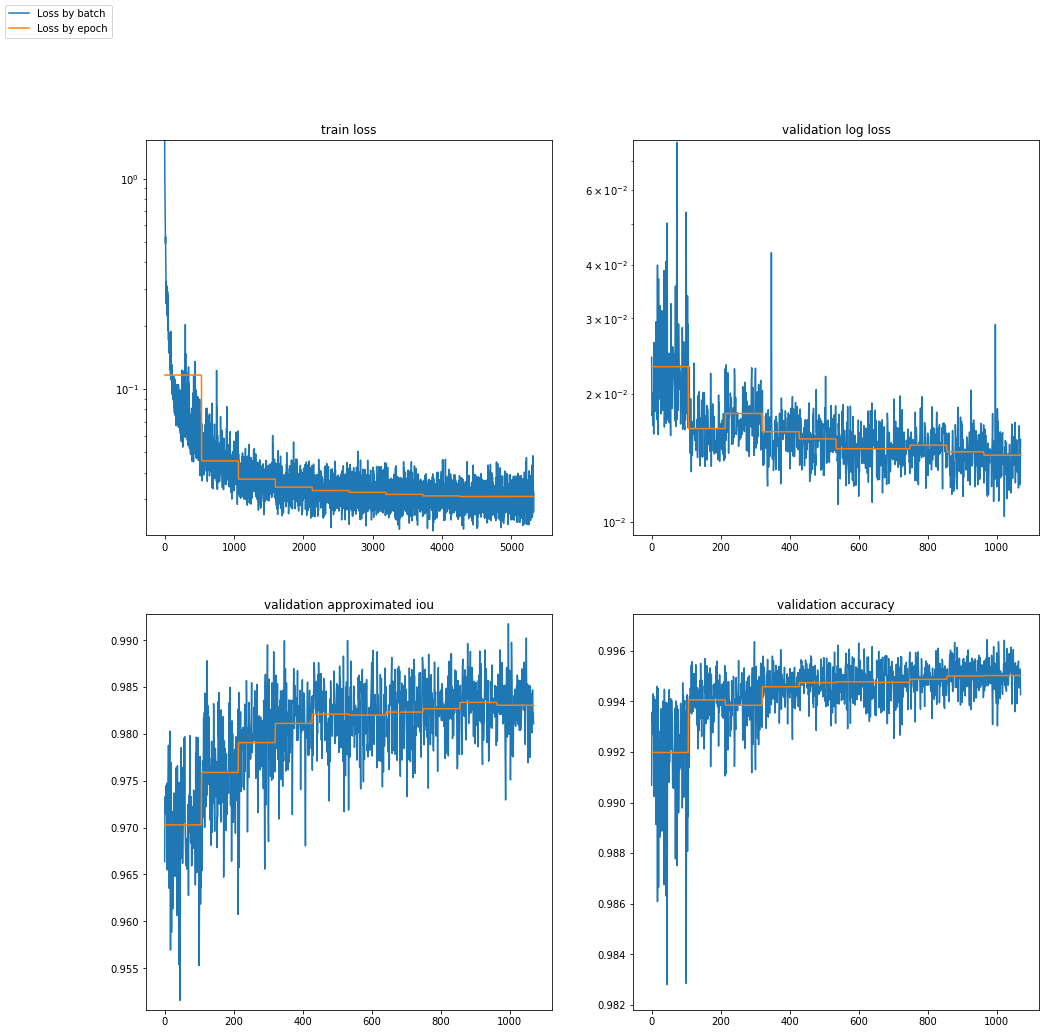

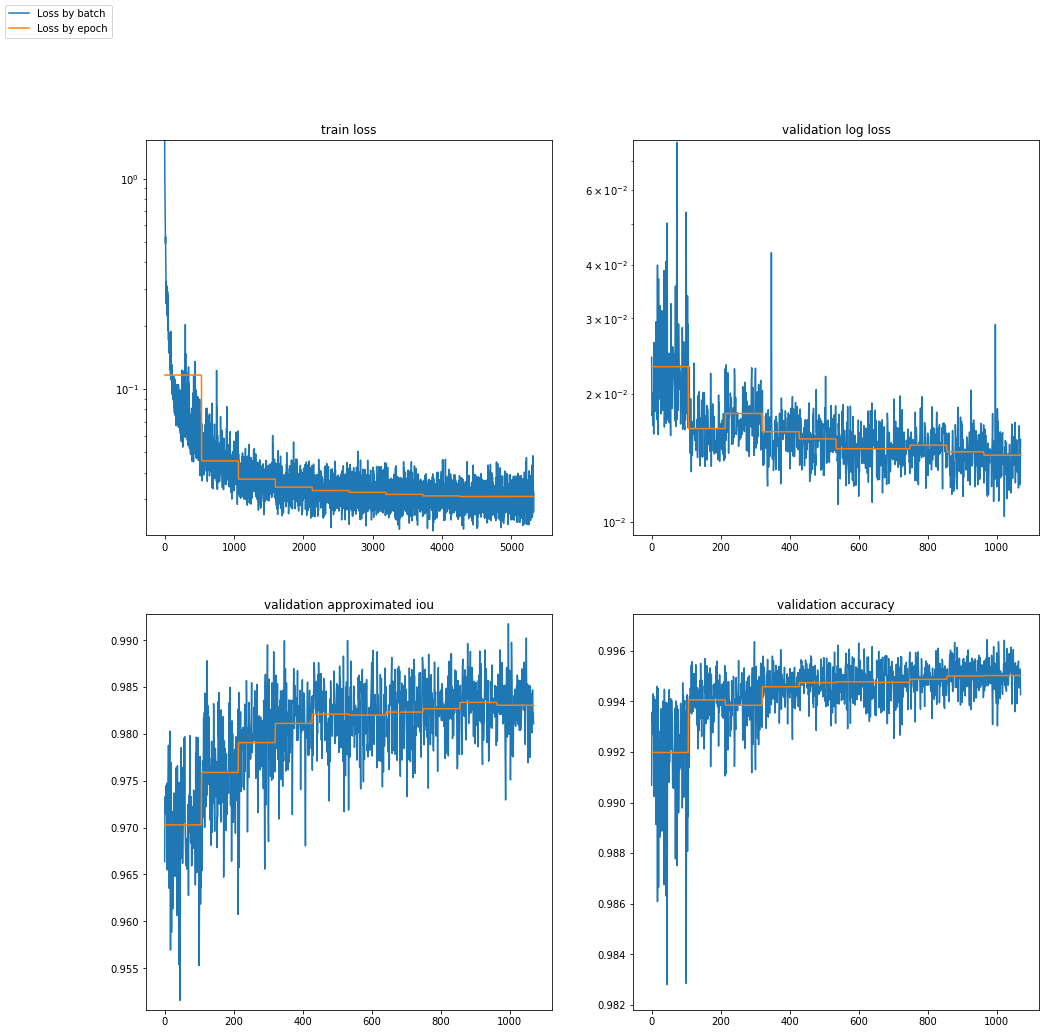

In [25]:
train_loss = []
val_cum_loss = []
val_log_loss = []
val_iou_loss = []
val_acc_loss = []

for epoch in range(num_epochs):
    start_time = time.time()
    
    train_loss.append([])
    apply_on_batches(
        ids=train_ids, 
        functions=[train_function], 
        results=[train_loss[-1]], 
        params=[
            (
                np.float32(learning_rate * learning_rate_decay ** epoch), 
                np.float32(alpha), 
                np.float32(smooth_const),
            )
        ],
        epoch=epoch, 
        validation_step=40, 
        limit=int(len(train_ids) / batch_size * 0.2),
        iterations_name='train'
    )
    
    val_cum_loss.append([])
    val_log_loss.append([])
    val_iou_loss.append([])
    val_acc_loss.append([])
    apply_on_batches(
        ids=val_ids, 
        functions=[
            cum_loss_function, log_loss_function, iou_loss_function, acc_loss_function
        ], 
        results=[
            val_cum_loss[-1], val_log_loss[-1], val_iou_loss[-1], val_acc_loss[-1]
        ], 
        params=[
            (np.float32(alpha), np.float32(smooth_const)), 
#             (),
            (), 
            (np.float32(smooth_const), ), 
            ()
        ], 
        epoch=epoch, 
        validation_step=40, 
        limit=int(len(val_ids) / batch_size * 0.2),
        iterations_name='validation'
    )
    
    display.clear_output(wait=True)

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(np.mean(train_loss[epoch])))
    print("  validation loss:\t\t{:.6f}".format(np.mean(val_cum_loss[epoch])))
    
    plot_learning_progress(epoch, train_loss, val_log_loss, val_iou_loss, val_acc_loss)

    dump(
        lasagne.layers.get_all_param_values(net['output_flattened']), 
        os.path.join(weights_dir, 'UNet_params_ep{:03}.jbl'.format(epoch))
    )

In [ ]:
# 1. Сделать график обучения и ошибки по батчам/эпохам - done
# 2. Сделать уменьшающийся learning rate - done
# 3. Сделать веса пикселей(или классов) в loss
# 4. Добавить IoU в loss + слежение в процессе обучения - done
# 5. Добавить регуляризацию в loss
# 6. Добавить negative sampling(оставлять патчи из плохих батчей в следующую эпоху)